In [47]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [48]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [49]:

trainset = datasets.ImageFolder('train', transform=transform)
valset = datasets.ImageFolder('val', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [50]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


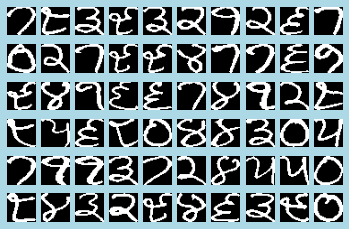

In [51]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [52]:
input_size = 1024
hidden_sizes = [256, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[1], output_size),
                            nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [53]:
def labelTransform(labels:torch.Tensor,no_of_cls:int):
    ndArr = np.zeros((len(labels),no_of_cls))
    ndLbls = labels.numpy()
    for i, arr in enumerate(ndArr):
       arr[ndLbls[i]]=1
    return torch.tensor(ndArr,dtype=torch.float32) 

In [54]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities

criterion = nn.NLLLoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,labels) #calculate the loss


In [55]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-1.5424e-03, -1.0667e-03, -6.5804e-04,  ..., -1.3263e-03,
         -1.3263e-03, -1.0667e-03],
        [-1.0563e-03, -1.5737e-04, -2.6179e-04,  ...,  8.7440e-05,
          8.7440e-05, -1.6483e-04],
        [-1.2751e-04, -1.7858e-04, -1.7858e-04,  ...,  9.2614e-04,
          1.5643e-03,  9.2614e-04],
        ...,
        [ 9.1479e-04,  7.9566e-04,  7.9566e-04,  ..., -1.0968e-03,
          2.6423e-04,  6.1937e-04],
        [ 3.4557e-04,  1.8145e-04,  7.3131e-06,  ...,  2.8907e-06,
          3.5963e-04,  7.7573e-04],
        [ 2.1314e-03,  1.6508e-03,  1.5965e-04,  ..., -3.1459e-03,
         -3.2207e-03, -1.0639e-03]])


In [56]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    cnt=0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        cnt+=images.shape[0]
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {} no of images {}".format(e, running_loss/len(trainloader),cnt))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.269824340939522 no of images 1000
Epoch 1 - Training loss: 2.09795780479908 no of images 1000
Epoch 2 - Training loss: 1.7974908873438835 no of images 1000
Epoch 3 - Training loss: 1.3636107668280602 no of images 1000
Epoch 4 - Training loss: 0.9015961736440659 no of images 1000
Epoch 5 - Training loss: 0.5408177319914103 no of images 1000
Epoch 6 - Training loss: 0.32873125560581684 no of images 1000
Epoch 7 - Training loss: 0.22306809108704329 no of images 1000
Epoch 8 - Training loss: 0.17469076346606016 no of images 1000
Epoch 9 - Training loss: 0.14274579333141446 no of images 1000
Epoch 10 - Training loss: 0.12170481774955988 no of images 1000
Epoch 11 - Training loss: 0.10598411364480853 no of images 1000
Epoch 12 - Training loss: 0.0929016477894038 no of images 1000
Epoch 13 - Training loss: 0.08438113681040704 no of images 1000
Epoch 14 - Training loss: 0.07196136051788926 no of images 1000

Training Time (in minutes) = 0.09735155502955119


In [57]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 4


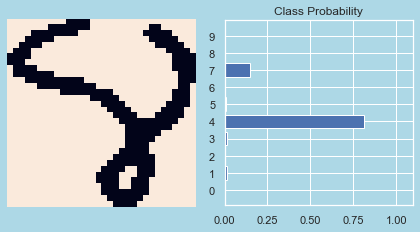

In [58]:
images, labels = next(iter(valloader))

img = images[0].view(1, input_size)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 32, 32), ps)

In [59]:
correct_count, all_count = 0, 0
pred_label_arr = []
true_label_arr =[]
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 1024)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    pred_label_arr.append(pred_label)
    true_label_arr.append(true_label)
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 178

Model Accuracy = 0.949438202247191


In [60]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


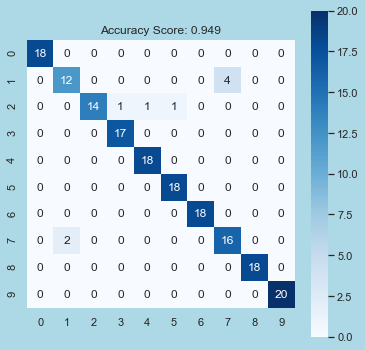

Overall Accuracy Score: 0.949
Classwise Accuracy Score: [1.         0.96629213 0.98314607 0.99438202 0.99438202 0.99438202
 1.         0.96629213 1.         1.        ]


In [61]:

confusionMatrixAndAccuracyReport(true_label_arr,pred_label_arr)